Coraline Assignment

Choose any problem on a link below that can represent your skill in Data science by following the CRISP-DM process.
https://www.kaggle.com/c/m5-forecasting-accuracy

What we are looking to evaluate:
1. Business Understanding and Problem Formulation
2. Data Understanding / EDA process
3. Modeling: Model / Feature selection
4. Model Evaluation
5. Business Impact / Insights


# Project Overview

In this project, I will use modern machine learning models to forecast the sales of product in Walmart. 

## Section 1: Business Understanding and Problem Formulation

In Walmart, the world's largest company by revenue, Sales Forecasting is a crucial area in the field of Business Management. It helps the store retailers to maintain their Stocks according to the demand they are expecting, thus maximizing the profit and minimizing the loss of time and stock. Forecasting can drive sales by processing just-in-time orders efficiently.

The data covers stores in three US states (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events. Together, this robust dataset can be used to improve forecasting accuracy.

Thus, I addressed the objective to 2 main following questions:
##### - What are the main features influencing the sales of the product in Walmart?
##### - Is different months and weekdays affect the sales of the product?

## Section 2: Data Understanding / EDA process

In [1]:
#import neccessary package for analysis and model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import math
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, metrics
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
import datetime
import xgboost as xgb
import gc
import calendar
from sklearn.cluster import KMeans
import multiprocessing as mp
from scipy.sparse import csr_matrix,hstack
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import pickle
import time
from itertools import cycle

color_pal=plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle=cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

encoder = preprocessing.LabelEncoder()

warnings.filterwarnings("ignore")

%matplotlib inline

pd.set_option('display.max_columns', 100)

In [2]:
# Credit: The reduce_mem_usage function has been taken from 
# https://gist.github.com/tkazusa/4d9e26d403c73755edc6b77b5b053a43

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and str(col_type)!= 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


### Gather

In [3]:
#Gather the data from csv file

sales = pd.read_csv('data/sales_train_validation.csv')
calendar = pd.read_csv('data/calendar.csv')
prices = pd.read_csv('data/sell_prices.csv')


In [4]:
print("Shape of calender.csv",calendar.shape)
print("Shape of sell_price.csv",prices.shape)
print("Shape of sales train validation.csv",sales.shape)

Shape of calender.csv (1969, 14)
Shape of sell_price.csv (6841121, 4)
Shape of sales train validation.csv (30490, 1919)


In [5]:
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


### Calendar dataset

In [6]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [7]:
print('event_name_1 types for products:\n')
print(calendar.event_name_1.value_counts())

print('\nevent_type_1 types for products:\n')
print(calendar.event_type_1.value_counts())

print('\nevent_name_2 types for products:\n')
print(calendar.event_name_2.value_counts())

print('\nevent_type_2 types for products:\n')
print(calendar.event_type_2.value_counts())

event_name_1 types for products:

SuperBowl              6
Pesach End             6
Ramadan starts         6
ValentinesDay          6
NBAFinalsEnd           6
NBAFinalsStart         6
MemorialDay            6
Mother's day           6
Purim End              6
StPatricksDay          6
LentWeek2              6
LentStart              6
PresidentsDay          6
MartinLutherKingDay    5
OrthodoxChristmas      5
EidAlAdha              5
NewYear                5
Chanukah End           5
Christmas              5
Thanksgiving           5
VeteransDay            5
IndependenceDay        5
Halloween              5
ColumbusDay            5
LaborDay               5
Eid al-Fitr            5
Cinco De Mayo          5
OrthodoxEaster         5
Easter                 5
Father's day           4
Name: event_name_1, dtype: int64

event_type_1 types for products:

Religious    55
National     52
Cultural     37
Sporting     18
Name: event_type_1, dtype: int64

event_name_2 types for products:

Father's day    

The Price and Calendar datasets will be used to merge with the sales dataset which will help is find holiday event, weekly and annual trends.

### Sales dataset

In [8]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,...,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,3,0,0,0,1,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,1,0,...,5,3,1,0,0,0,1,2,3,0,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,2,1,1,0,3,1,1,2,1,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [9]:
sales.shape

(30490, 1919)

In [10]:
sales.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1904', 'd_1905', 'd_1906', 'd_1907', 'd_1908', 'd_1909', 'd_1910',
       'd_1911', 'd_1912', 'd_1913'],
      dtype='object', length=1919)

In [11]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [12]:
sales[sales.columns[:]].describe().T

,count,mean,std,min,25%,50%,75%,max
d_1,30490.0,1.070220,5.126689,0.0,0.0,0.0,0.0,360.0
d_2,30490.0,1.041292,5.365468,0.0,0.0,0.0,0.0,436.0
d_3,30490.0,0.780026,3.667454,0.0,0.0,0.0,0.0,207.0
d_4,30490.0,0.833454,4.415141,0.0,0.0,0.0,0.0,323.0
d_5,30490.0,0.627944,3.379344,0.0,0.0,0.0,0.0,296.0
...,...,...,...,...,...,...,...,...
d_1909,30490.0,1.159167,2.876026,0.0,0.0,0.0,1.0,88.0
d_1910,30490.0,1.149000,2.950364,0.0,0.0,0.0,1.0,77.0
d_1911,30490.0,1.328862,3.358012,0.0,0.0,0.0,1.0,141.0
d_1912,30490.0,1.605838,4.089422,0.0,0.0,0.0,2.0,171.0


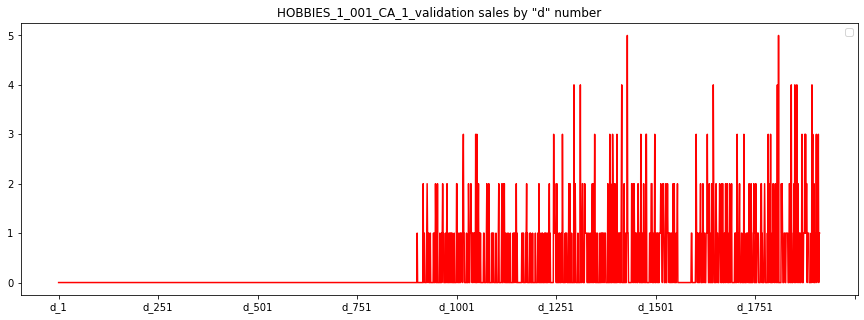

In [13]:
#Let's visual on a single product sales

d_cols = [c for c in sales.columns if 'd_' in c]

sales.loc[sales['id'] == 'HOBBIES_1_001_CA_1_validation'].set_index('id')[d_cols].T.plot(figsize=(15, 5),
          title='HOBBIES_1_001_CA_1_validation sales by "d" number',
          color='red')

plt.legend('')
plt.show()


### Data Preprocessing

#### Clean

In [14]:
print("For prices dataset")
print("Duplicated values: {}" .format(prices.duplicated().sum()))
print("Missing values: {}" .format(prices.isnull().sum()))
print("---------------------------")

print("For calendar dataset")
print("Duplicated values: {}" .format(calendar.duplicated().sum()))
print("Missing values: {}" .format(calendar.isnull().sum()))
print("---------------------------")

print("For prices dataset")
print("Duplicated values: {}" .format(prices.duplicated().sum()))
print("Missing values: {}" .format(prices.isnull().sum()))
print("---------------------------")

For prices dataset
Duplicated values: 0
Missing values: store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64
---------------------------
For calendar dataset
Duplicated values: 0
Missing values: date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64
---------------------------
For prices dataset
Duplicated values: 0
Missing values: store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64
---------------------------


There are rows contain NaN in event_type_1, event_type_2, event_name_1, and event_name_2

In [15]:
calendar = calendar.fillna("no_event")

In [16]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,no_event,no_event,no_event,no_event,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,no_event,no_event,no_event,no_event,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,no_event,no_event,no_event,no_event,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,no_event,no_event,no_event,no_event,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,no_event,no_event,no_event,no_event,1,0,1


In [17]:
sales = reduce_mem_usage(sales)

Memory usage of dataframe is 446.40 MB
Memory usage after optimization is: 95.16 MB
Decreased by 78.7%


In [18]:
calendar = reduce_mem_usage(calendar)

Memory usage of dataframe is 0.21 MB
Memory usage after optimization is: 0.19 MB
Decreased by 8.7%


In [19]:
prices = reduce_mem_usage(prices)

Memory usage of dataframe is 208.77 MB
Memory usage after optimization is: 45.76 MB
Decreased by 78.1%


#### Merging to single dataframe df

In [20]:
d_colnames = []
for i in range(1, 1914):
    d_colnames.append('d_'+str(i))
    
sales_new = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
        value_vars=d_colnames, var_name='day_number', value_name='units_sold')

In [21]:
sales_new

,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
...,...,...,...,...,...,...,...,...
58327365,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1913,1
58327366,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1913,0
58327367,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1913,0
58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1913,3


In [22]:
#taking only last 28 data days of test

# d_colnames = []
# for i in range(1914,1942):
#     d_colnames.append("d_"+str(i))
    
# sales_2_new = pd.melt(sales_2, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
#         value_vars=d_colnames, var_name='day_number', value_name='units_sold')

In [23]:
# for i in range(1942,1970):
#     sales_2['d_'+str(i)]=0

In [24]:
#Create futures sales data

# d_colnames = []
# for i in range(1942,1970):
#     d_colnames.append("d_"+str(i))
    
# sales_2_future = pd.melt(sales_2, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
#         value_vars=d_colnames, var_name='day_number', value_name='units_sold')

In [25]:
#Merge all These 3 datasets to get final df train

data = sales_new.merge(calendar,left_on='day_number', right_on='d', how='left')
data = data.merge(prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')
data.drop(['day_number','weekday','d',], inplace = True, axis = 1)
data['sell_price'].fillna(0, inplace = True)
data = reduce_mem_usage(data)
# data.to_csv('data/final_data.csv',index=False)

Memory usage of dataframe is 1948.29 MB
Memory usage after optimization is: 1948.29 MB
Decreased by 0.0%


In [26]:
#Merge all These 3 datasets to get final df test

# data_test = sales_2_new.merge(calendar,left_on='day_number', right_on='d', how='left')
# data_test = data_test.merge(prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')
# data_test.drop(['day_number','weekday','d',], inplace = True, axis = 1)
# data_test['sell_price'].fillna(0, inplace = True)
# data_test = reduce_mem_usage(data_test)
# data_test.to_csv('data/final_data_test.csv',index=False)

In [27]:
#Merge all These 3 datasets to get final df future

# data_future = sales_2_future.merge(calendar,left_on='day_number', right_on='d', how='left')
# data_future = data_future.merge(prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')
# data_future.drop(['day_number','weekday','d',], inplace = True, axis = 1)
# data_future['sell_price'].fillna(0, inplace = True)
# data_future = reduce_mem_usage(data_future)
# data_future.to_csv('data/final_data_future.csv',index=False)

In [28]:
#Load saved dataframe
# data = pd.read_csv('data/final_data.csv')
# test = pd.read_csv('data/final_data_test.csv')
# future = pd.read_csv('data/final_data_future.csv')

In [29]:
%%time
data = reduce_mem_usage(data)
# test = reduce_mem_usage(test)
# future = reduce_mem_usage(future)


Memory usage of dataframe is 1948.29 MB
Memory usage after optimization is: 1948.29 MB
Decreased by 0.0%
Wall time: 2.2 s


In [30]:
data

,id,item_id,dept_id,cat_id,store_id,state_id,units_sold,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,11101,1,1,2011,no_event,no_event,no_event,no_event,0,0,0,0.000000
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,11101,1,1,2011,no_event,no_event,no_event,no_event,0,0,0,0.000000
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,11101,1,1,2011,no_event,no_event,no_event,no_event,0,0,0,0.000000
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,11101,1,1,2011,no_event,no_event,no_event,no_event,0,0,0,0.000000
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,11101,1,1,2011,no_event,no_event,no_event,no_event,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58327365,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1,2016-04-24,11613,2,4,2016,no_event,no_event,no_event,no_event,0,0,0,2.980469
58327366,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,2016-04-24,11613,2,4,2016,no_event,no_event,no_event,no_event,0,0,0,2.480469
58327367,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,2016-04-24,11613,2,4,2016,no_event,no_event,no_event,no_event,0,0,0,3.980469
58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,3,2016-04-24,11613,2,4,2016,no_event,no_event,no_event,no_event,0,0,0,1.280273


### Exploratory Data Analysis

#### Visual on catrgorical data

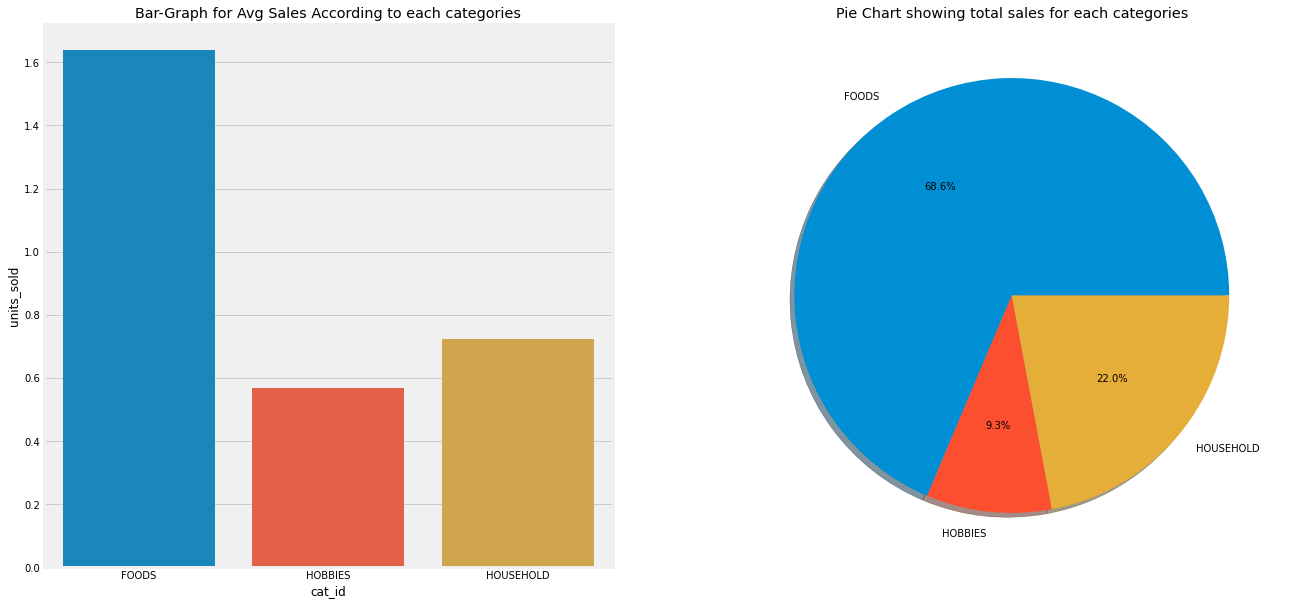

In [310]:
df=data.groupby('cat_id').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='cat_id',y='units_sold',data=df)
plt.title("Bar-Graph for Avg Sales According to each categories")

plt.subplot(122)
df=data.groupby('cat_id').sum()
df.reset_index(level=0,inplace=True)
df['perc']=df['units_sold']/sum(df['units_sold'].values)*100
plt.pie(df['perc'].values,labels=df['cat_id'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing total sales for each categories")
plt.show()

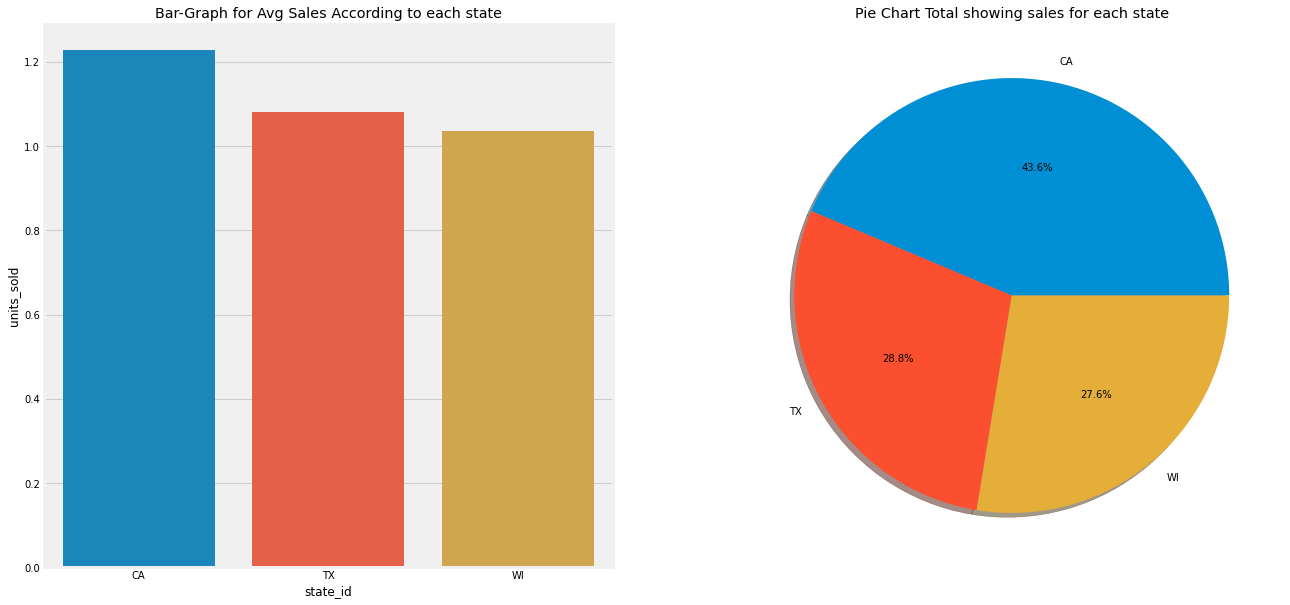

In [311]:
#Total Sales for each State(Barplot+Pie Chart)
#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html
df=data.groupby('state_id').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='state_id',y='units_sold',data=df)
plt.title("Bar-Graph for Avg Sales According to each state")

df=data.groupby('state_id').sum()
df.reset_index(level=0,inplace=True)
df['perc']=df['units_sold']/sum(df['units_sold'].values)*100
plt.subplot(122)
plt.pie(df['perc'].values,labels=df['state_id'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart Total showing sales for each state")
plt.show()

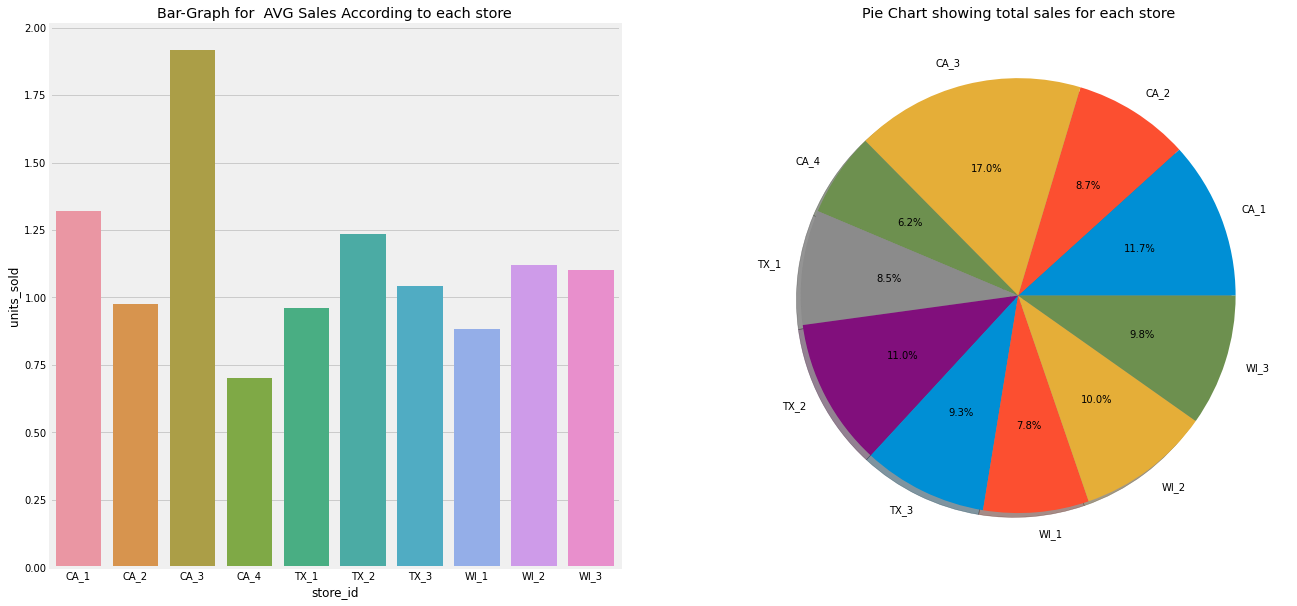

In [312]:
#Total Sales for each store(Bargraph+pieChart)
#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html
df=data.groupby('store_id').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='store_id',y='units_sold',data=df)
plt.title("Bar-Graph for  AVG Sales According to each store")
df=data.groupby('store_id').sum()
df.reset_index(level=0,inplace=True)
df['perc']=df['units_sold']/sum(df['units_sold'].values)*100
plt.subplot(122)
plt.pie(df['perc'].values,labels=df['store_id'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing total sales for each store")

plt.show()

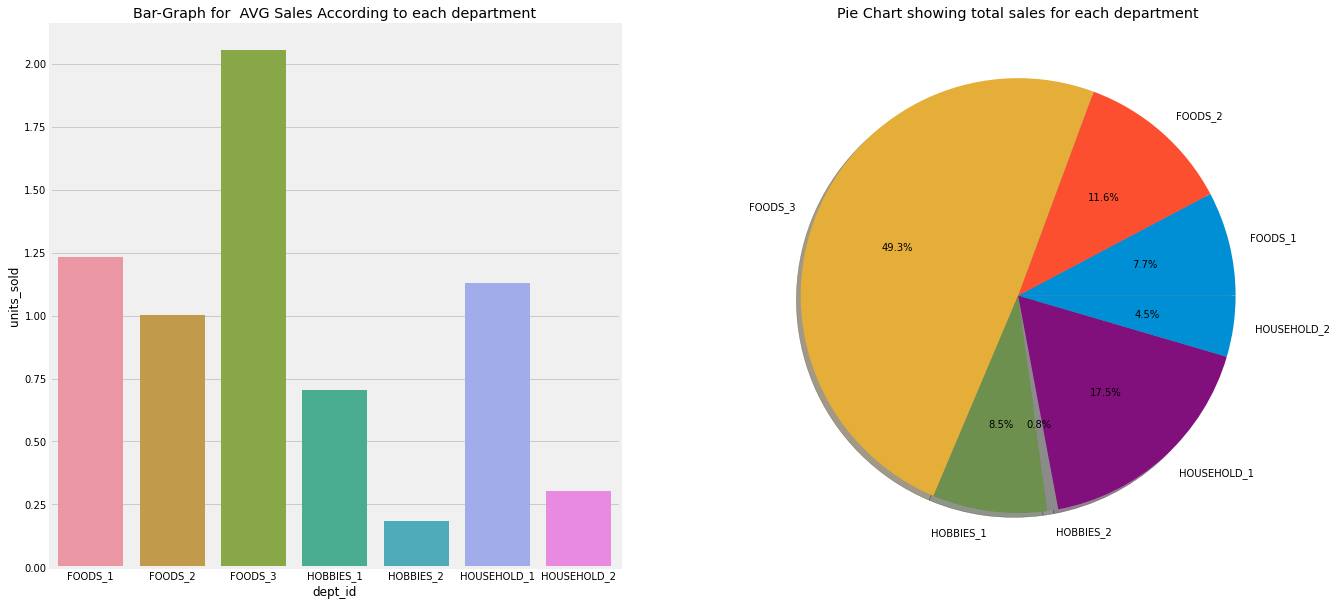

In [313]:
#Total Sales for each store(Bargraph+pieChart)
#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html
df=data.groupby('dept_id').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='dept_id',y='units_sold',data=df)
plt.title("Bar-Graph for  AVG Sales According to each department")
df=data.groupby('dept_id').sum()
df.reset_index(level=0,inplace=True)
df['perc']=df['units_sold']/sum(df['units_sold'].values)*100
plt.subplot(122)
plt.pie(df['perc'].values,labels=df['dept_id'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing total sales for each department")

plt.show()

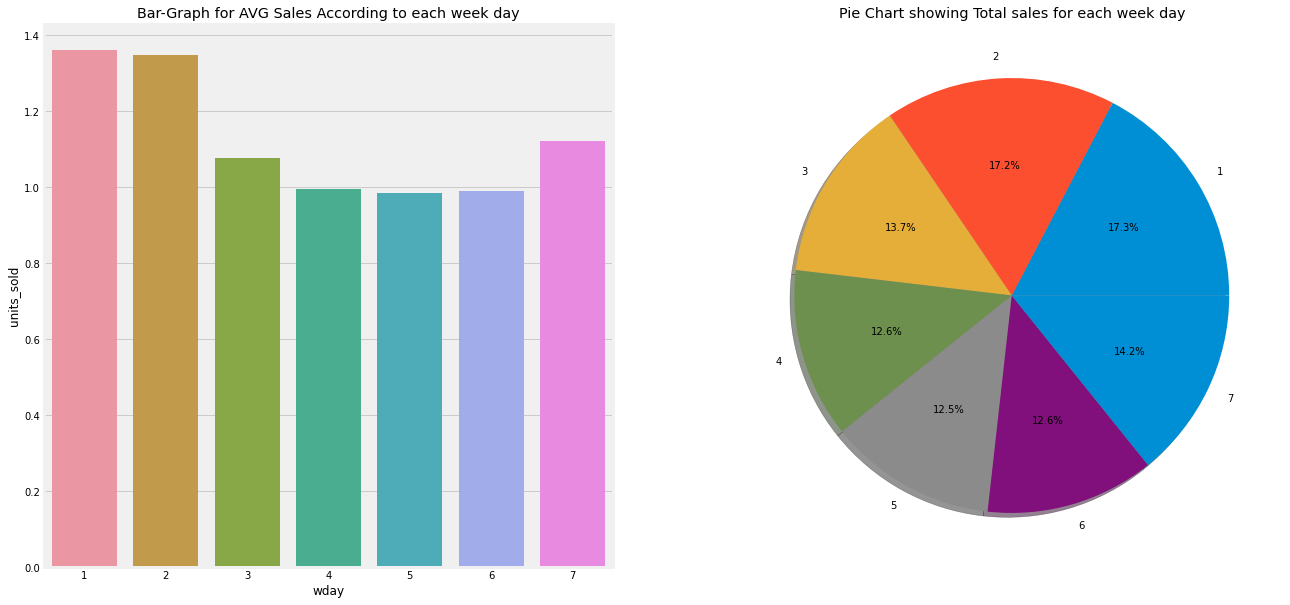

In [314]:
#Total Sales for each day of week(Barplot+PieChart)
#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html
df=data.groupby('wday').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='wday',y='units_sold',data=df)
plt.title("Bar-Graph for AVG Sales According to each week day")

df=data.groupby('wday').sum()
df.reset_index(level=0,inplace=True)
df['perc']=df['units_sold']/sum(df['units_sold'].values)*100
plt.subplot(122)
plt.pie(df['perc'].values,labels=df['wday'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing Total sales for each week day")

plt.show()

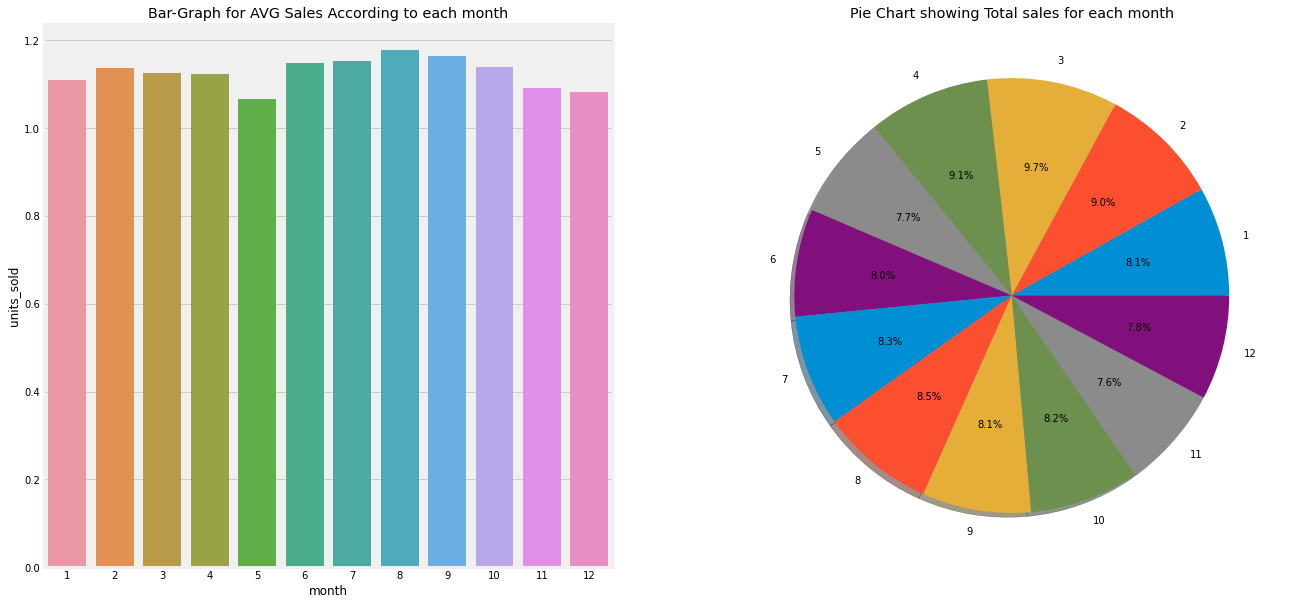

In [315]:
#Total Sales for each month(Barplot+pie chart)
#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html
df=data.groupby('month').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='month',y='units_sold',data=df)
plt.title("Bar-Graph for AVG Sales According to each month")

df=data.groupby('month').sum()
df.reset_index(level=0,inplace=True)
df['perc']=df['units_sold']/sum(df['units_sold'].values)*100
plt.subplot(122)
plt.pie(df['perc'].values,labels=df['month'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing Total sales for each month")

plt.show()

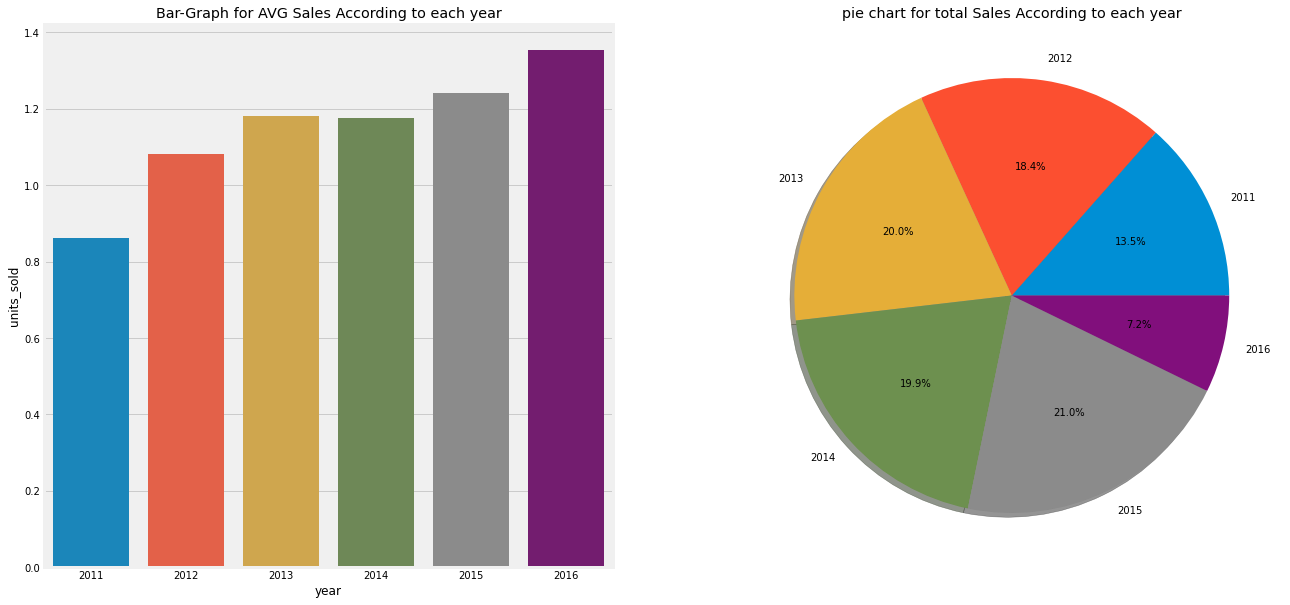

In [316]:
#Total Sales for each year(bar plot+pie chart)
#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html

df=data.groupby('year').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)

sns.barplot(x='year',y='units_sold',data=df)
plt.title("Bar-Graph for AVG Sales According to each year")

plt.subplot(122)
df=data.groupby('year').sum()
df.reset_index(level=0,inplace=True)
df['year_avg']=df['units_sold']/sum(df['units_sold'].values)*100
plt.pie(df['year_avg'].values,labels=df['year'].values,shadow=True,autopct='%1.1f%%')

plt.title("pie chart for total Sales According to each year")
plt.show()

### Visual on time series data

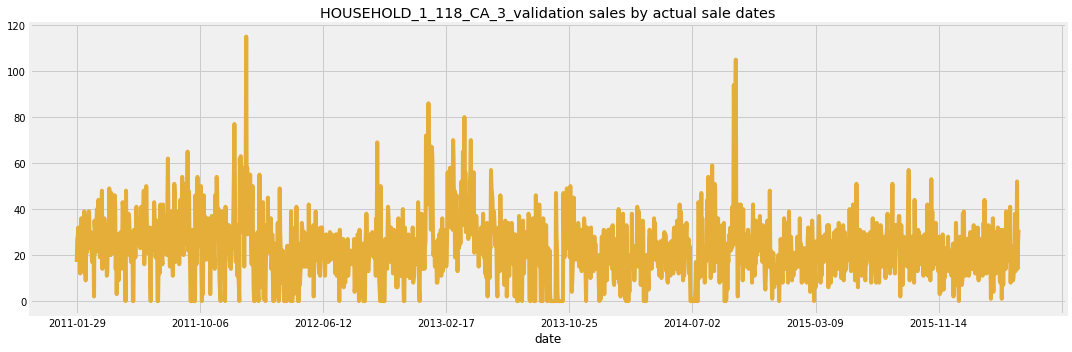

In [317]:
ids = ['FOODS_3_090_CA_3_validation', 'HOBBIES_1_234_CA_3_validation', 'HOUSEHOLD_1_118_CA_3_validation', 'HOBBIES_1_001_CA_1_validation']
examples = []

# General function to extract specific item Id values from sales_train_evaluation dataset
for i in range(len(ids)):
    # Merge calendar date with sales_train_evaluation date
    examples.append(sales.loc[sales['id']== ids[i]][d_cols].T) # Fetch a specific Id and transform it as column
    examples[i] = examples[i].rename(columns={examples[i].columns.values[0] : ids[i]}) # Rename column e.g 8412 (location Id) to the proper name
    examples[i] = examples[i].reset_index().rename(columns={'index':'d'}) # Reset index so, d_cols are not index and then, rename index as d
    examples[i] = examples[i].merge(calendar) # Merge two dataframe on the bases of column named d

graph_ids = [2]
fig, axs = plt.subplots(len(graph_ids),1,figsize=(15,10)) 
if len(graph_ids) != 1 : axs=axs.flatten() 

ax_id=0
for graph_id in graph_ids:
    # Set date as the index of dataframe to be plotted properly and only fetch specific Id sales value
    examples[graph_id].set_index('date')[ids[graph_id]] \
    .plot(figsize=(15,5), color=next(color_cycle), title= f'{ids[graph_id]} sales by actual sale dates', ax=axs[ax_id] if len(graph_ids)!=1 else axs)
    
    ax_id+=1
plt.tight_layout()
plt.show()

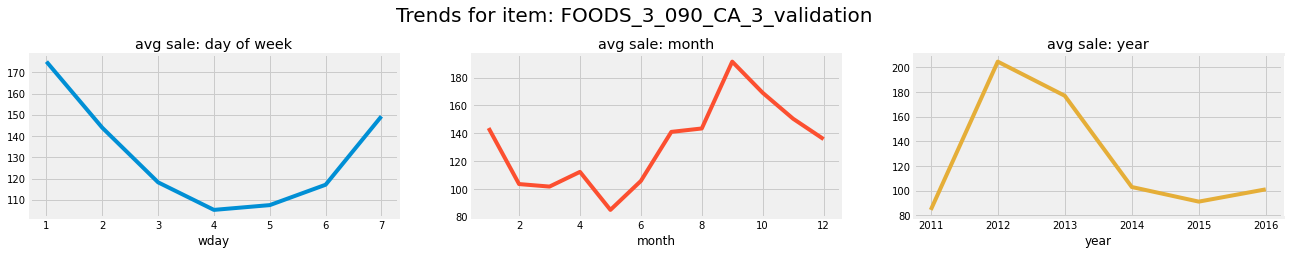

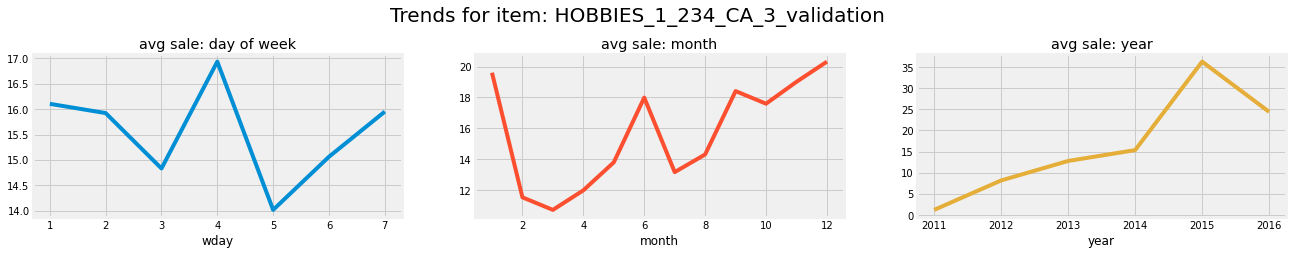

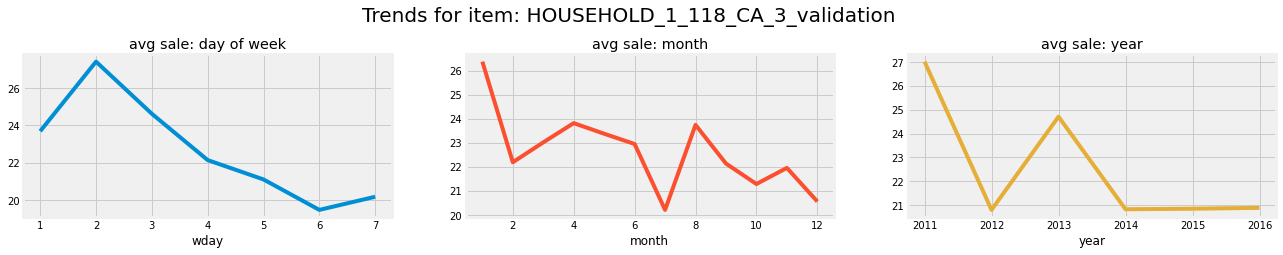

In [318]:
for i in [0, 1, 2]:
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,3))
    # Groupby wday colum and do mean or count etc. to values of other columns & then, extract the specific sales Id column  
    examples[i].groupby('wday').mean()[ids[i]] \
    .plot(kind='line', title='avg sale: day of week', color=color_pal[0], ax=ax1)
    
    examples[i].groupby('month').mean()[ids[i]] \
    .plot(kind='line', title='avg sale: month', color=color_pal[1], ax=ax2)
    
    examples[i].groupby('year').mean()[ids[i]] \
    .plot(kind='line', title='avg sale: year', color=color_pal[2], ax=ax3)
    
    fig.suptitle(f'Trends for item: {ids[i]}', size=20, y=1.1)

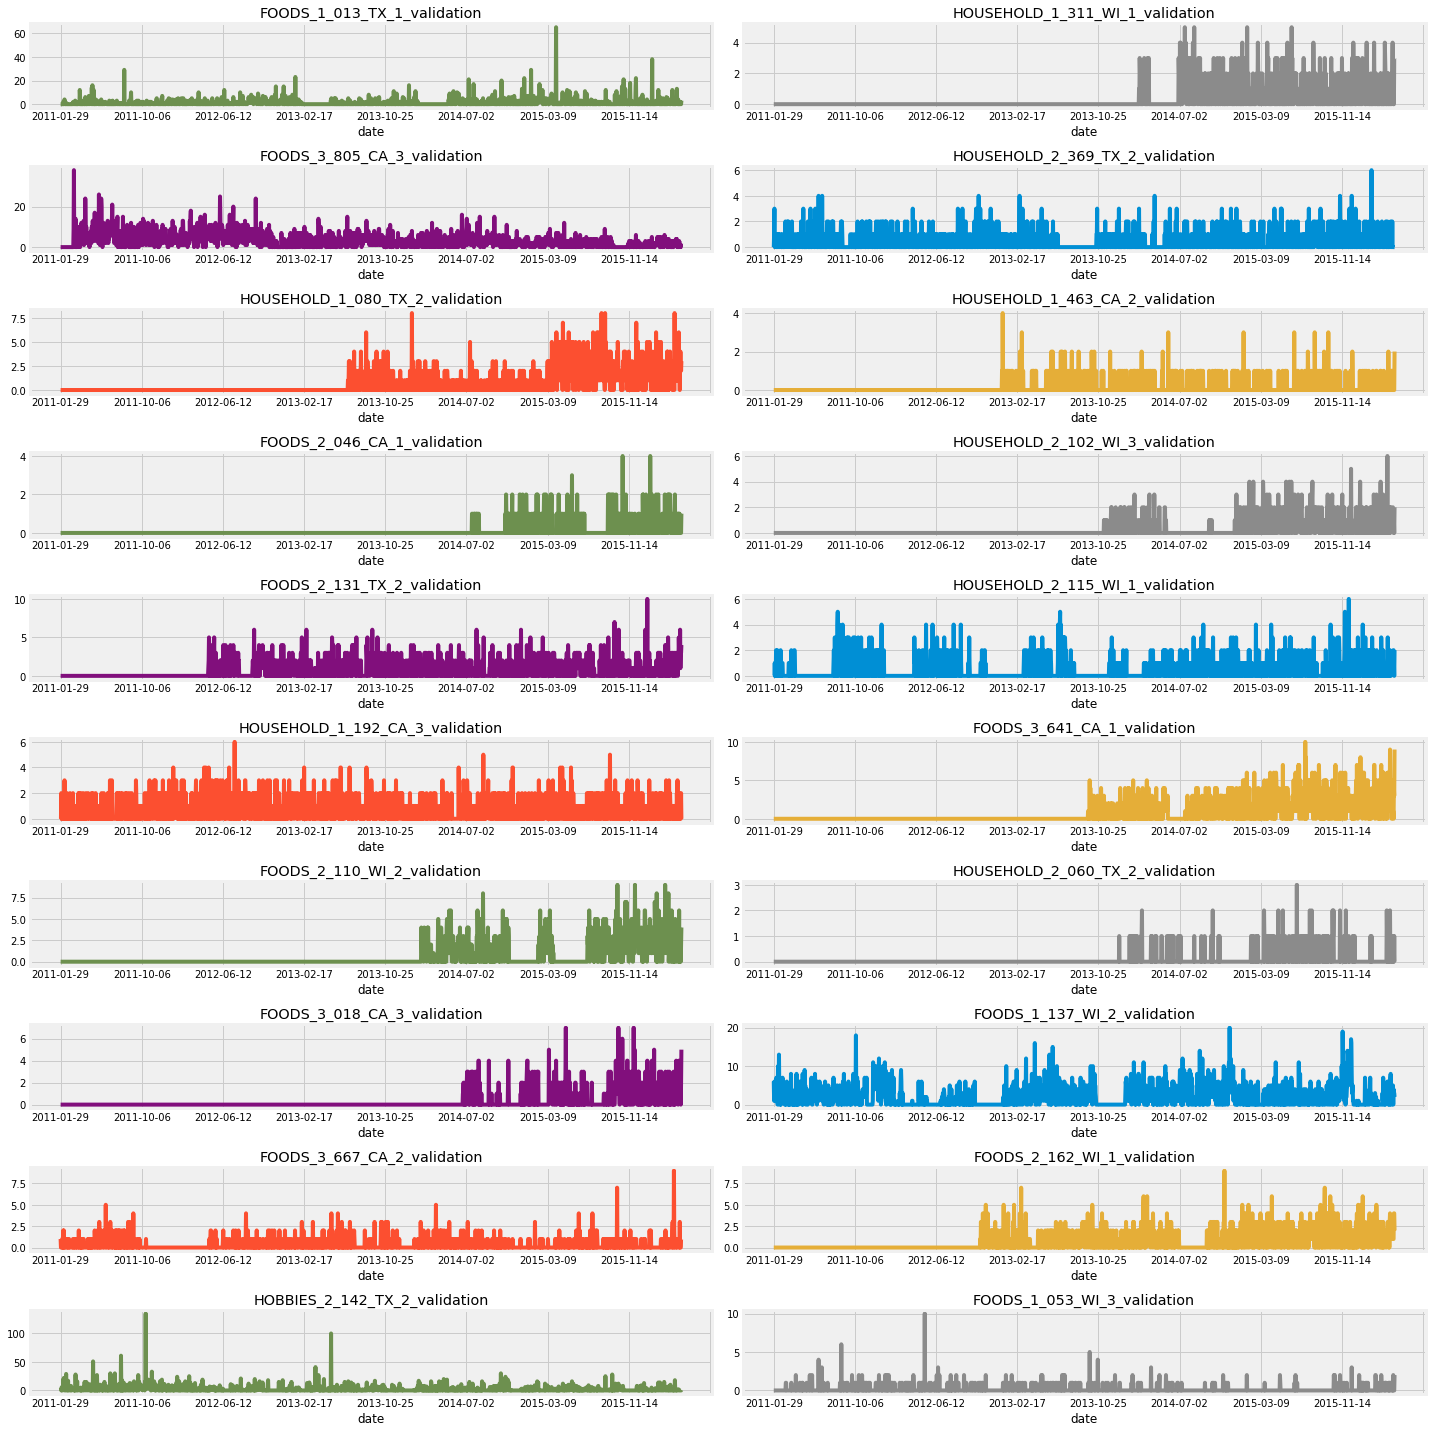

In [319]:
twenty_examples = sales.sample(20, random_state=529) # Sample random 20 samples from the sales dataframe
list_of_sampled_id = list(twenty_examples['id']) # Extract the list of sampled id of items so as to just keep these id values in the dataframe eventually
twenty_examples = twenty_examples.set_index('id')[d_cols].T # Set the index of dataframe to be id column, select only the d columns & transform the 
twenty_examples = twenty_examples.reset_index().rename(columns={'index':'d'})
twenty_examples = twenty_examples.merge(calendar)
twenty_examples = twenty_examples.set_index('date')[list_of_sampled_id] 


fig, axs = plt.subplots(10,2,figsize=(20,20))
axs = axs.flatten()

axs_id=0
for item in twenty_examples.columns:
    twenty_examples[item].plot(title=item, color=next(color_cycle), ax=axs[axs_id])
    axs_id+=1
plt.tight_layout()
plt.show()

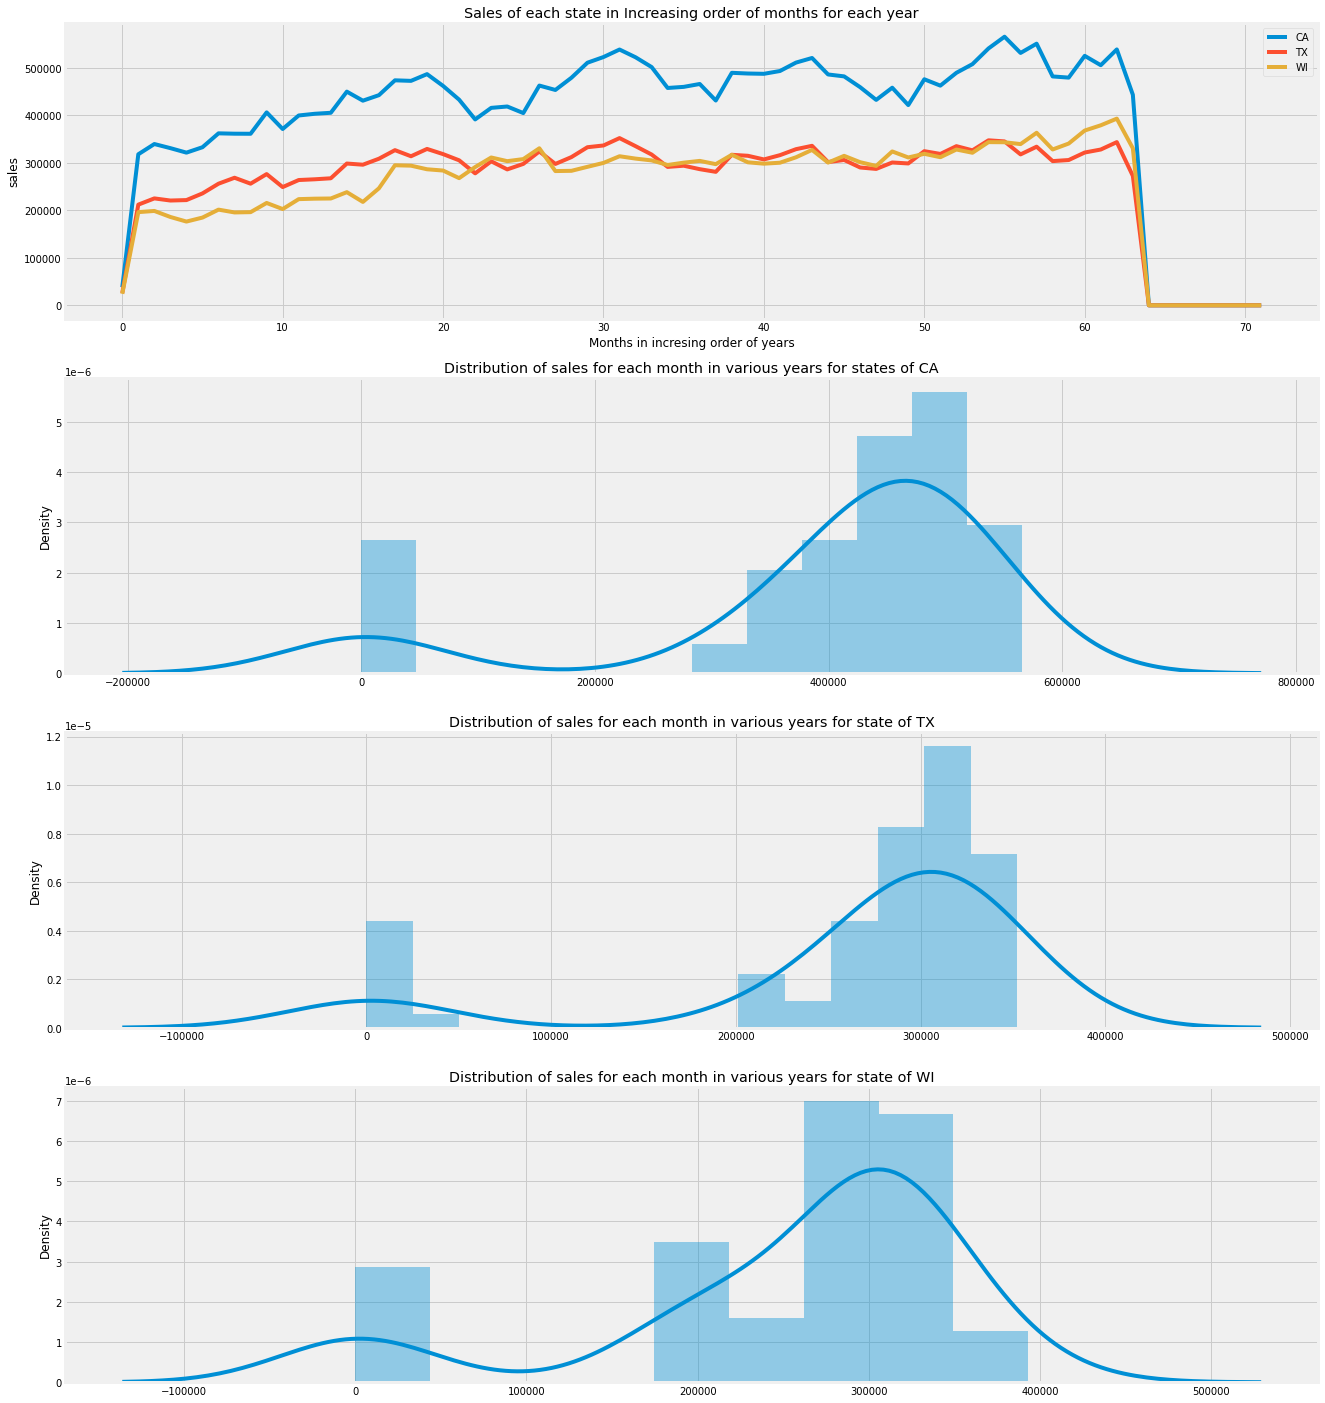

In [320]:
df=data.groupby(['year','month','state_id']).sum()
df.reset_index(level=[0,1,2],inplace=True)
plt.figure(figsize=(20,25))
plt.subplot(411)
plt.plot(df[df['state_id']=="CA"]['units_sold'].values,label="CA")
plt.plot(df[df['state_id']=="TX"]['units_sold'].values,label="TX")
plt.plot(df[df['state_id']=="WI"]['units_sold'].values,label="WI")
plt.xlabel('Months in incresing order of years')
plt.ylabel('sales')
plt.title("Sales of each state in Increasing order of months for each year")
plt.legend()

plt.subplot(412)
sns.distplot(df[df['state_id']=="CA"]['units_sold'].values)
plt.title("Distribution of sales for each month in various years for states of CA")

plt.subplot(413)
sns.distplot(df[df['state_id']=="TX"]['units_sold'].values)
plt.title("Distribution of sales for each month in various years for state of TX")

plt.subplot(414)
sns.distplot(df[df['state_id']=="WI"]['units_sold'].values)
plt.title("Distribution of sales for each month in various years for state of WI")

plt.show()

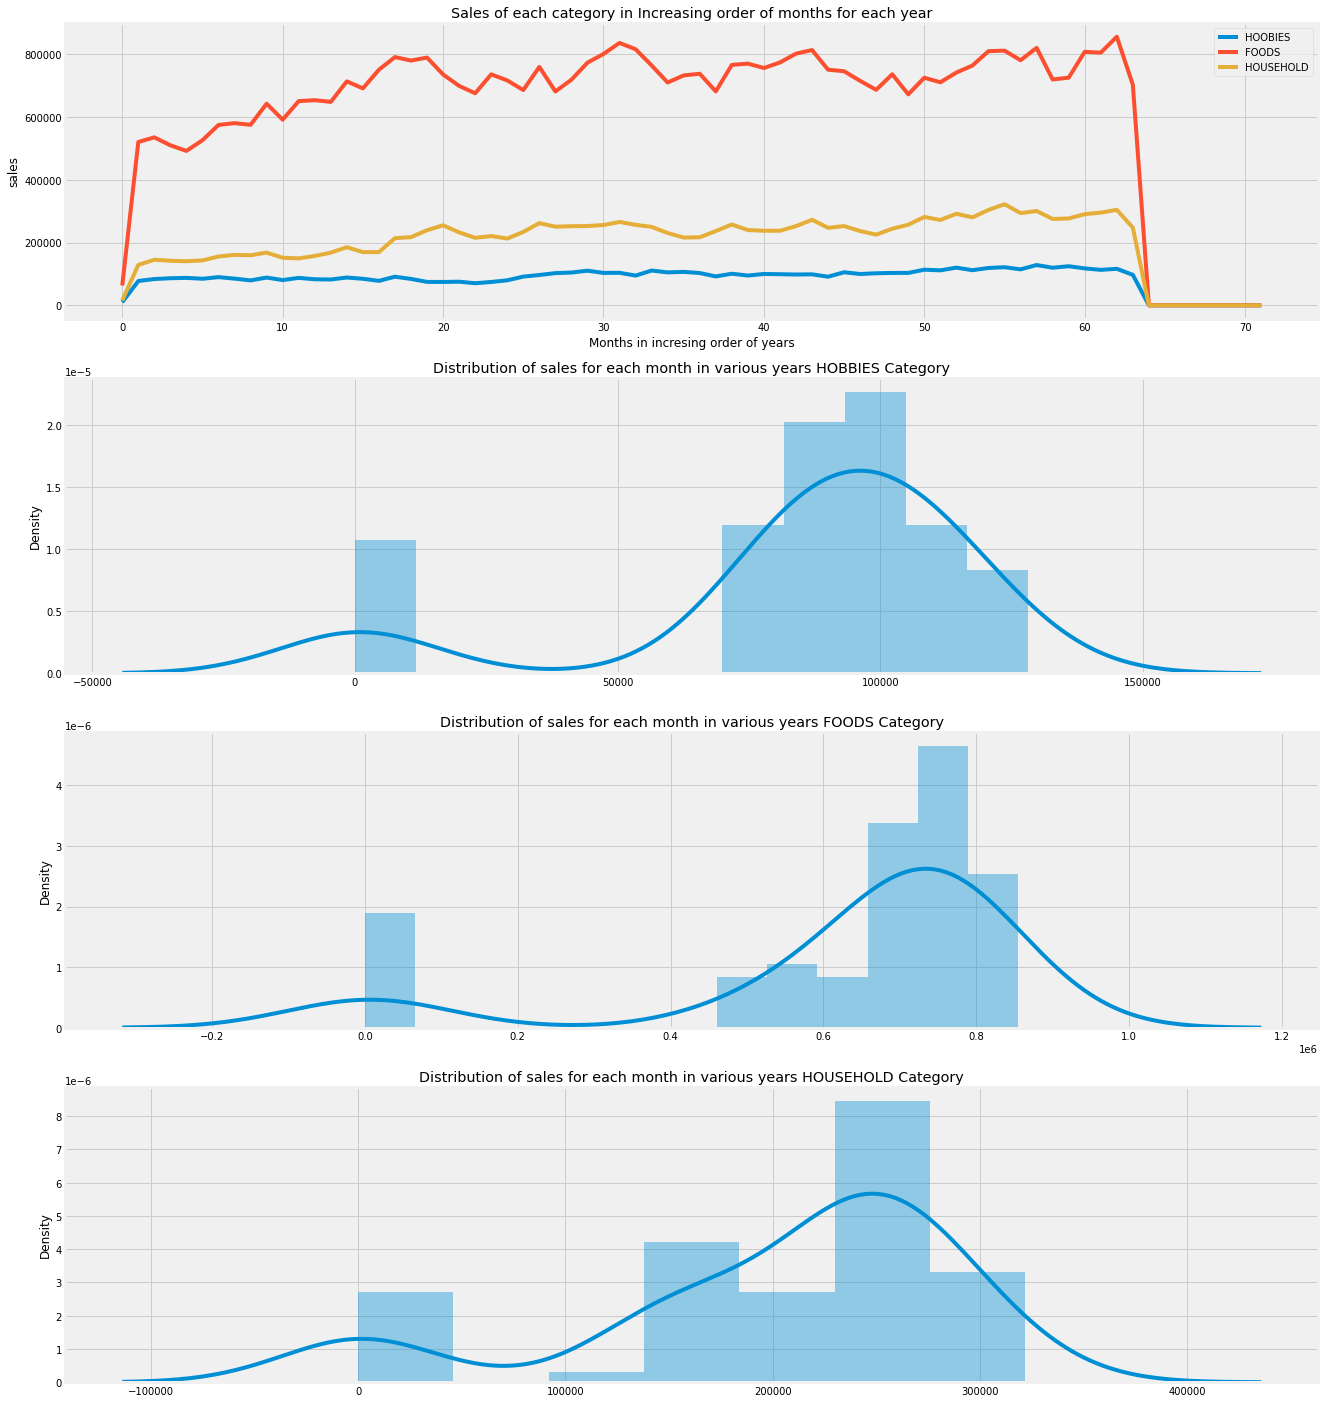

In [323]:
df=data.groupby(['year','month','cat_id']).sum()
df.reset_index(level=[0,1,2],inplace=True)
plt.figure(figsize=(20,25))
plt.subplot(411)
plt.plot(df[df['cat_id']=="HOBBIES"]['units_sold'].values,label="HOOBIES")
plt.plot(df[df['cat_id']=="FOODS"]['units_sold'].values,label="FOODS")
plt.plot(df[df['cat_id']=="HOUSEHOLD"]['units_sold'].values,label="HOUSEHOLD")
plt.xlabel('Months in incresing order of years')
plt.ylabel('sales')
plt.title("Sales of each category in Increasing order of months for each year")
plt.legend()
plt.subplot(412)
sns.distplot(df[df['cat_id']=="HOBBIES"]['units_sold'].values)
plt.title("Distribution of sales for each month in various years HOBBIES Category")


plt.subplot(413)
sns.distplot(df[df['cat_id']=="FOODS"]['units_sold'].values)
plt.title("Distribution of sales for each month in various years FOODS Category")


plt.subplot(414)
sns.distplot(df[df['cat_id']=="HOUSEHOLD"]['units_sold'].values)
plt.title("Distribution of sales for each month in various years HOUSEHOLD Category")

plt.show()

## Section 3: Model / Feature selection

### Very Unfortunately, there are some problems running in the model training process due to lag of memory in my computing resources, I decided to reduce the data to around one year from the latest date.

In [31]:
#Dropping the column

for col in range(1,1548):
    
    sales.drop(['d_'+str(col)], inplace = True, axis = 1)

#Reduce the category to food only
# sales = sales.loc[sales['cat_id']=='FOODS' ]

d_colnames = []
for i in range(1548, 1914):
    d_colnames.append('d_'+str(i))
    
sales_new = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
        value_vars=d_colnames, var_name='day_number', value_name='units_sold')


#Merge all These 3 datasets to get final df train
data = sales_new.merge(calendar,left_on='day_number', right_on='d', how='left')
data = data.merge(prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')
data.drop(['day_number','weekday','d',], inplace = True, axis = 1)
data['sell_price'].fillna(0, inplace = True)
data = reduce_mem_usage(data)

Memory usage of dataframe is 373.89 MB
Memory usage after optimization is: 373.89 MB
Decreased by 0.0%


### Feature Engineering

#### Dealing with caterogical data 

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11159340 entries, 0 to 11159339
Data columns (total 20 columns):
 #   Column        Dtype   
---  ------        -----   
 0   id            category
 1   item_id       category
 2   dept_id       category
 3   cat_id        category
 4   store_id      category
 5   state_id      category
 6   units_sold    int16   
 7   date          category
 8   wm_yr_wk      int16   
 9   wday          int8    
 10  month         int8    
 11  year          int16   
 12  event_name_1  category
 13  event_type_1  category
 14  event_name_2  category
 15  event_type_2  category
 16  snap_CA       int8    
 17  snap_TX       int8    
 18  snap_WI       int8    
 19  sell_price    float16 
dtypes: category(11), float16(1), int16(3), int8(5)
memory usage: 373.9 MB


In [34]:
def prep_categorical(df):
    """This function is for prepare catergorical data in dataframe"""
    categorical_col = list(data.dtypes[data.dtypes=='category'].index)
    categorical_col.remove('id')
    categorical_col.remove('date')
    categorical_col
    
    for feature in categorical_col:

        encoder = preprocessing.LabelEncoder()
        df[feature] = encoder.fit_transform(df[feature])
        
    return df


In [35]:
%%time
data = prep_categorical(data)

Wall time: 16.3 s


### In this analysis, Features that we could generate in this section will be:
#### Units sold related feature:
- Rolling mean 7 days on Unit_sold
- Rolling mean 30 days on Unit_sold
- Rolling mean 90 days on Unit_sold
- Rolling mean 180 days on Unit_sold
- Rolling std 7 days on Unit_sold
- Rolling std 7 days on Unit_sold
- Lagged Unit sold from 7 – 30 days

#### Price related feature:
- Price change in 7 days
- Price change in 30 days
- Rolling std 7 days on Price 
- Rolling std 30 days on Price

#### Time related feature:
- Week numbers
- Days
- Quarter number
- Seasonal

In [36]:
def get_season(x):
    """This function is used to get season in US according to various months"""
    
    if x in [12,1,2]:
        return 0        #"Winter"
    elif x in [3,4,5]:
        return 1        #"Spring"
    elif x in [6,7,8]:
        return 2        #"Summer"
    else:
        return 3        #"Autumn"
    
def month_start(x):
    """This is used to check if day is begining of month"""
    
    day=calendar.datetime.date.fromisoformat(x).day
    
    return 1 if day==1 else 0
    
def month_end(x):
    """This is used to check if day is end of month"""
    
    day=calendar.datetime.date.fromisoformat(x).day
    month=calendar.datetime.date.fromisoformat(x).month
    year=calendar.datetime.date.fromisoformat(x).year
    leap_yr=(year%4==0) # to check if it is a leap year
    val=(day==31 and month==1) or (day==29 if leap_yr else day==28) or (day==31 and month==3) or (day==30 and month==4) or\
        (day==31 and month==5) or (day==30 and month==6) or (day==31 and month==7) or (day==31 and month==8) or\
        (day==30 and month==9) or (day==31 and month==10) or (day==30 and month==11) or (day==31 and month==12)
    
    return 1 if val else 0
    
def quater_begin(x):
    """This is used to check if day is begining of quater"""
    
    day=calendar.datetime.date.fromisoformat(x).day
    month=calendar.datetime.date.fromisoformat(x).month
    
    return 1 if (day==1 and (month in [1,4,7,9])) else 0

def quater_end(x):
    """This is used to check if day is end of quater"""
    
    day=calendar.datetime.date.fromisoformat(x).day
    month=calendar.datetime.date.fromisoformat(x).month
    if (day==31 and month==3) or (day==30 and month==6) or (day==30 and month==9) or (day==31 and month==12):
        return 1
    else:
        return 0
    
def year_start(x):
    """This is used to check if day is begining of year"""
    
    day=calendar.datetime.date.fromisoformat(x).day
    month=calendar.datetime.date.fromisoformat(x).month
    
    return 1 if (day==1 and month==1) else 0


def year_end(x):
    """This is used to check if day is end of year"""
    
    day=calendar.datetime.date.fromisoformat(x).day
    month=calendar.datetime.date.fromisoformat(x).month
    
    return 1 if (day==31 and month==12) else 0

def add_lagging_feature(data, lag_d =30):
    """This function is used to get lagging units sold in day"""
    
    for i in range(7,lag_d+1):
        
        data['lag_t' + str(i)] = data.groupby(['id'])['units_sold'].transform(lambda x: x.shift(i))
        
    return data

In [37]:
# Function to do feature engineering.
def feature_engineering(data):
    
    # units_sold features.
    data = add_lagging_feature(data,30)
    data['rolling_mean_t7'] = data.groupby(['id'])['units_sold'].transform(lambda x: x.shift(28).rolling(7).mean())
    data['rolling_std_t7'] = data.groupby(['id'])['units_sold'].transform(lambda x: x.shift(28).rolling(7).std())
    data['rolling_mean_t30'] = data.groupby(['id'])['units_sold'].transform(lambda x: x.shift(28).rolling(30).mean())
    data['rolling_mean_t90'] = data.groupby(['id'])['units_sold'].transform(lambda x: x.shift(28).rolling(90).mean())
    data['rolling_mean_t180'] = data.groupby(['id'])['units_sold'].transform(lambda x: x.shift(28).rolling(180).mean())
    data['rolling_std_t30'] = data.groupby(['id'])['units_sold'].transform(lambda x: x.shift(28).rolling(30).std())
    data = reduce_mem_usage(data)
    
    # Price features
    data['lag_price_t7'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(7))
    data['price_change_t7'] = (data['lag_price_t7'] - data['sell_price']) / (data['lag_price_t7'])
    data['rolling_price_max_t30'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1).rolling(30).max())
    data['price_change_t30'] = (data['rolling_price_max_t30'] - data['sell_price']) / (data['rolling_price_max_t30'])
    data['rolling_price_std_t7'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(7).std())
    data['rolling_price_std_t30'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(30).std())
    data.drop(['rolling_price_max_t30', 'lag_price_t7'], inplace = True, axis = 1)
    data = reduce_mem_usage(data)
    
    # Time features
    data['date'] = pd.to_datetime(data['date'])
    data['week'] = data['date'].dt.week
    data['day'] = data['date'].dt.day
    data['day'] = data['date'].dt.quarter
    data['season'] = data['month'].apply(lambda x:get_season(x))
    
#     data = reduce_mem_usage(data)
    
    
    return data


In [38]:
%%time
data = feature_engineering(data)
gc.collect()

Memory usage of dataframe is 3204.67 MB
Memory usage after optimization is: 1012.34 MB
Decreased by 68.4%
Memory usage of dataframe is 1289.05 MB
Memory usage after optimization is: 1225.19 MB
Decreased by 5.0%
Wall time: 4min 19s


18

In [39]:
data

,id,item_id,dept_id,cat_id,store_id,state_id,units_sold,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_t7,lag_t8,lag_t9,lag_t10,lag_t11,lag_t12,lag_t13,lag_t14,lag_t15,lag_t16,lag_t17,lag_t18,lag_t19,lag_t20,lag_t21,lag_t22,lag_t23,lag_t24,lag_t25,lag_t26,lag_t27,lag_t28,lag_t29,lag_t30,rolling_mean_t7,rolling_std_t7,rolling_mean_t30,rolling_mean_t90,rolling_mean_t180,rolling_std_t30,price_change_t7,price_change_t30,rolling_price_std_t7,rolling_price_std_t30,week,day,season
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,2,2015-04-25,11513,1,4,2015,28,4,0,0,0,0,0,8.257812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,2,1
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,0,2015-04-25,11513,1,4,2015,28,4,0,0,0,0,0,3.970703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,2,1
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,0,2015-04-25,11513,1,4,2015,28,4,0,0,0,0,0,2.970703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,2,1
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,2,2015-04-25,11513,1,4,2015,28,4,0,0,0,0,0,4.640625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,2,1
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,2,2015-04-25,11513,1,4,2015,28,4,0,0,0,0,0,2.880859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11159335,FOODS_3_823_WI_3_validation,1432,2,0,9,2,1,2016-04-24,11613,2,4,2016,28,4,0,0,0,0,0,2.980469,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5.960464e-08,0.266602,0.611328,0.677734,0.583496,0.0,0.0,0.0,0.000000,16,2,1
11159336,FOODS_3_824_WI_3_validation,1433,2,0,9,2,0,2016-04-24,11613,2,4,2016,28,4,0,0,0,0,0,2.480469,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.206665,16,2,1
11159337,FOODS_3_825_WI_3_validation,1434,2,0,9,2,0,2016-04-24,11613,2,4,2016,28,4,0,0,0,0,0,3.980469,0.0,1.0,2.0,0.0,0.0,0.0,4.0,2.0,2.0,0.0,0.0,4.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.714355,9.511719e-01,1.233398,0.899902,0.638672,0.935059,0.0,0.0,0.0,0.000000,16,2,1
11159338,FOODS_3_826_WI_3_validation,1435,2,0,9,2,3,2016-04-24,11613,2,4,2016,28,4,0,0,0,0,0,1.280273,1.0,0.0,0.0,3.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,2.0,1.0,1.571289,1.272461e+00,1.166992,1.188477,1.405273,1.084961,0.0,0.0,0.0,0.000000,16,2,1


In [40]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [41]:
data.isna().sum()

id                             0
item_id                        0
dept_id                        0
cat_id                         0
store_id                       0
state_id                       0
units_sold                     0
date                           0
wm_yr_wk                       0
wday                           0
month                          0
year                           0
event_name_1                   0
event_type_1                   0
event_name_2                   0
event_type_2                   0
snap_CA                        0
snap_TX                        0
snap_WI                        0
sell_price                     0
lag_t7                    213430
lag_t8                    243920
lag_t9                    274410
lag_t10                   304900
lag_t11                   335390
lag_t12                   365880
lag_t13                   396370
lag_t14                   426860
lag_t15                   457350
lag_t16                   487840
lag_t17   

In [42]:
data.dropna(inplace=True)

In [43]:
data

,id,item_id,dept_id,cat_id,store_id,state_id,units_sold,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_t7,lag_t8,lag_t9,lag_t10,lag_t11,lag_t12,lag_t13,lag_t14,lag_t15,lag_t16,lag_t17,lag_t18,lag_t19,lag_t20,lag_t21,lag_t22,lag_t23,lag_t24,lag_t25,lag_t26,lag_t27,lag_t28,lag_t29,lag_t30,rolling_mean_t7,rolling_std_t7,rolling_mean_t30,rolling_mean_t90,rolling_mean_t180,rolling_std_t30,price_change_t7,price_change_t30,rolling_price_std_t7,rolling_price_std_t30,week,day,season
6311430,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,0,2015-11-18,11542,5,11,2015,28,4,0,0,0,0,0,8.257812,2.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.571289,1.133789e+00,0.600098,0.666504,0.539062,0.854980,0.0,0.0,0.0,0.000000,47,4,3
6311431,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,1,2015-11-18,11542,5,11,2015,28,4,0,0,0,0,0,3.970703,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.233276,0.422119,0.355469,0.678711,0.0,0.0,0.0,0.000000,47,4,3
6311432,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,0,2015-11-18,11542,5,11,2015,28,4,0,0,0,0,0,2.970703,0.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.571289,5.346680e-01,0.533203,0.500000,0.422119,0.628906,0.0,0.0,0.0,0.000000,47,4,3
6311433,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,1,2015-11-18,11542,5,11,2015,28,4,0,0,0,0,0,4.640625,4.0,0.0,0.0,3.0,3.0,1.0,3.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,4.0,2.0,2.0,5.0,5.0,0.0,1.0,2.0,0.0,2.427734,2.371094e+00,1.533203,1.766602,2.044922,1.675781,0.0,0.0,0.0,0.000000,47,4,3
6311434,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,0,2015-11-18,11542,5,11,2015,28,4,0,0,0,0,0,2.880859,2.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,3.0,0.0,4.0,1.0,1.0,0.0,3.0,2.0,0.0,1.0,3.0,2.0,2.0,1.0,1.0,0.0,0.714355,7.558594e-01,1.266602,1.244141,1.078125,1.201172,0.0,0.0,0.0,0.000000,47,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11159335,FOODS_3_823_WI_3_validation,1432,2,0,9,2,1,2016-04-24,11613,2,4,2016,28,4,0,0,0,0,0,2.980469,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5.960464e-08,0.266602,0.611328,0.677734,0.583496,0.0,0.0,0.0,0.000000,16,2,1
11159336,FOODS_3_824_WI_3_validation,1433,2,0,9,2,0,2016-04-24,11613,2,4,2016,28,4,0,0,0,0,0,2.480469,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.206665,16,2,1
11159337,FOODS_3_825_WI_3_validation,1434,2,0,9,2,0,2016-04-24,11613,2,4,2016,28,4,0,0,0,0,0,3.980469,0.0,1.0,2.0,0.0,0.0,0.0,4.0,2.0,2.0,0.0,0.0,4.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.714355,9.511719e-01,1.233398,0.899902,0.638672,0.935059,0.0,0.0,0.0,0.000000,16,2,1
11159338,FOODS_3_826_WI_3_validation,1435,2,0,9,2,3,2016-04-24,11613,2,4,2016,28,4,0,0,0,0,0,1.280273,1.0,0.0,0.0,3.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,2.0,1.0,1.571289,1.272461e+00,1.166992,1.188477,1.405273,1.084961,0.0,0.0,0.0,0.000000,16,2,1


## Section 4: Model Evaluation

In [44]:
import time
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [45]:
# Separating X and y

x = data.drop(['id','units_sold','date'], axis=1)
y = data.units_sold

# Splitting into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

#### Model1: XGBoosting Model

In [46]:
model_xgb = xgb.XGBRegressor(seed=42, n_jobs=-1)

model_xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [47]:
y_pred = model_xgb.predict(x_test)

In [48]:
scores_train = cross_val_score(model_xgb, x_train, y_train, cv=3, n_jobs=6 ,scoring='r2').mean()
scores_test = cross_val_score(model_xgb, x_test, y_test, cv=3, n_jobs=6 ,scoring='r2').mean()

In [49]:
print("Training accuracy:%.4f" % scores_train.mean())
print("Test accuracy:%.4f" % scores_test.mean())

Training accuracy:0.6519
Test accuracy:0.6379


In [51]:
filename = 'data/xgb_model.pkl'
pickle.dump(model_xgb, open(filename, 'wb'))

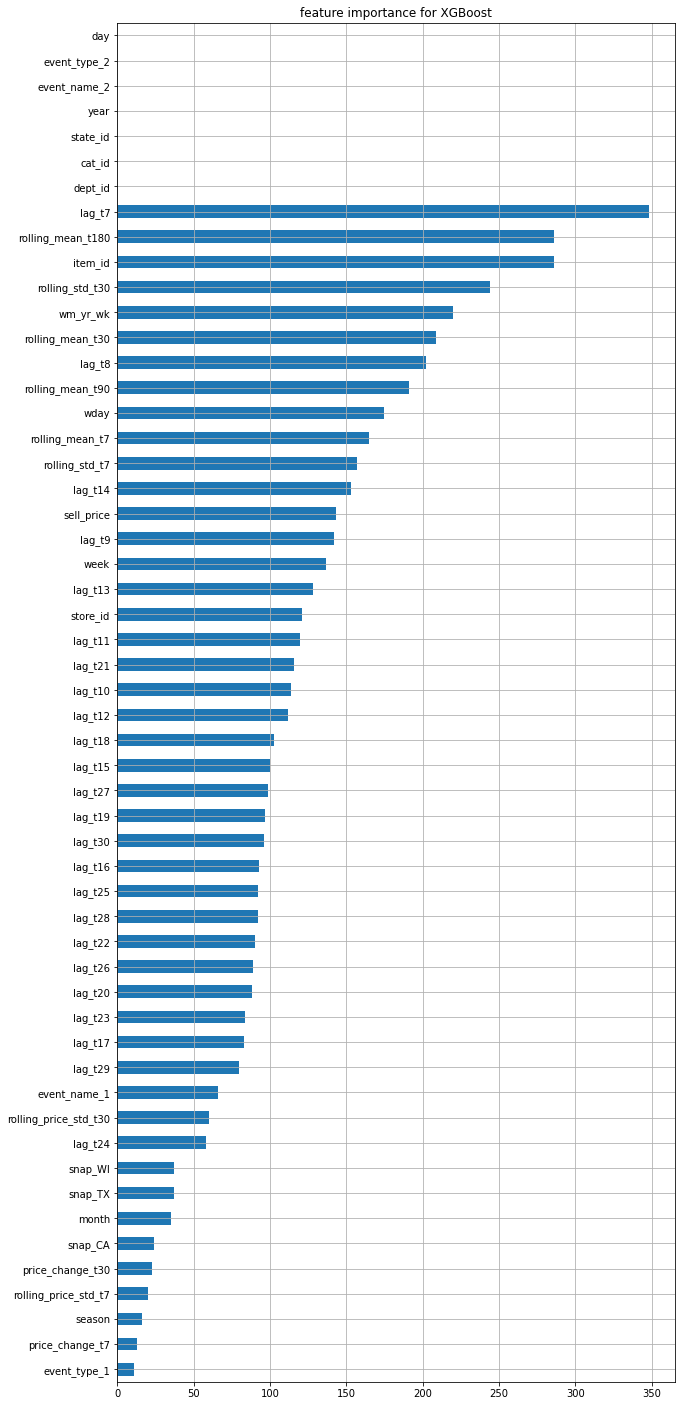

In [52]:

plt.figure(figsize=(10,25))

feature_importance_xgb = pd.Series(model_xgb.get_booster().get_score(importance_type='weight'), index = x_train.columns).sort_values(ascending = True)
feature_importance_xgb.plot.barh()
plt.title('feature importance for XGBoost')
plt.grid()

#### Model2: Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
model_rf.fit(x, y) 

In [60]:
scores_train = cross_val_score(model_rf, x_train, y_train, cv=3, n_jobs=6 ,scoring='r2').mean()
scores_test = cross_val_score(model_rf, x_test, y_test, cv=3, n_jobs=6 ,scoring='r2').mean()

In [61]:
print("Training accuracy:%.4f" % scores_train.mean())
print("Test accuracy:%.4f" % scores_test.mean())

Training accuracy:0.7120
Test accuracy:0.6842


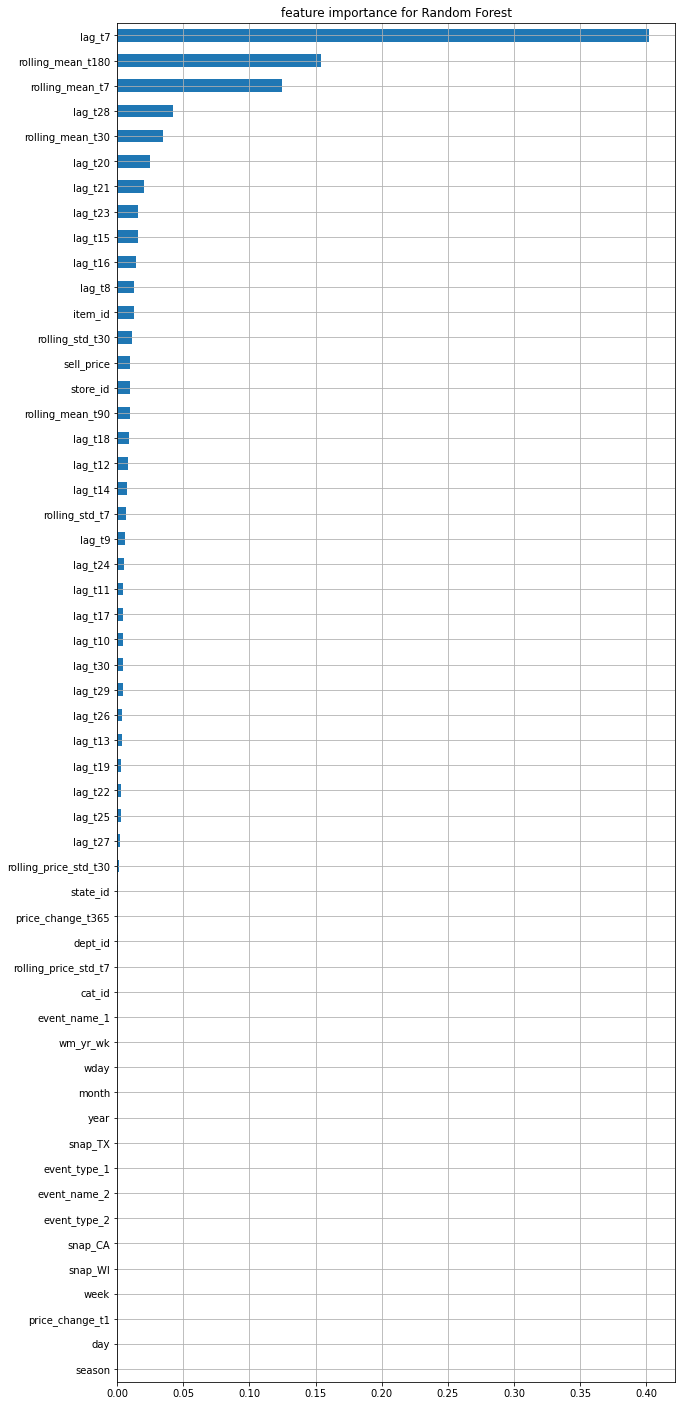

In [62]:
plt.figure(figsize=(10,25))

feature_importance_rf = pd.Series(model_rf.estimators_[0].feature_importances_, index = x_train.columns).sort_values(ascending = True)
feature_importance_rf.plot.barh()
plt.title('feature importance for Random Forest')
plt.grid()


From both of the model, i will go in with Random Forest since the initial accuracy (R2) is better than XGBoost

### Model Refining

To improve the model performance, I decided to use GridsearchCV to tuning for the best parameter on Random Forest model

In [64]:
param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [5,10,15,20],
                'min_samples_split': [2, 10, 20],
                'min_samples_leaf': [2, 10,15, 20],
                }
gcv = GridSearchCV(RandomForestRegressor(random_state=12,n_jobs=-1), param_grid)
gcv.fit(x_train, y_train)

KeyboardInterrupt: 

In [ ]:
gcv.best_params_

In [ ]:
param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [20, 50 ,100],
                'min_samples_split': [2, 10],
                'min_samples_leaf': [2, 10],
                }
gcv = GridSearchCV(RandomForestRegressor(random_state=12,n_jobs=-1), param_grid)
gcv.fit(x_train, y_train)

In [ ]:
gcv.best_params_

In [133]:
model_rf2 = RandomForestRegressor(n_estimators=100,max_depth=20,max_features='auto',min_samples_leaf=2,min_samples_split=2, oob_score=True,n_jobs=-1)
model_rf2.fit(x_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, n_jobs=-1,
                      oob_score=True)

In [134]:
scores_train = cross_val_score(model_rf2, x_train, y_train, cv=10, n_jobs=-1 ,scoring='r2').mean()
scores_test = cross_val_score(model_rf2, x_test, y_test, cv=10, n_jobs=-1 ,scoring='r2').mean()

In [135]:
print("Training accuracy:%.4f" % scores_train.mean())
print("Test accuracy:%.4f" % scores_test.mean())

Training accuracy:0.7434
Test accuracy:0.7119


In [137]:
y_pred_rf2 = model_rf2.predict(x_test)

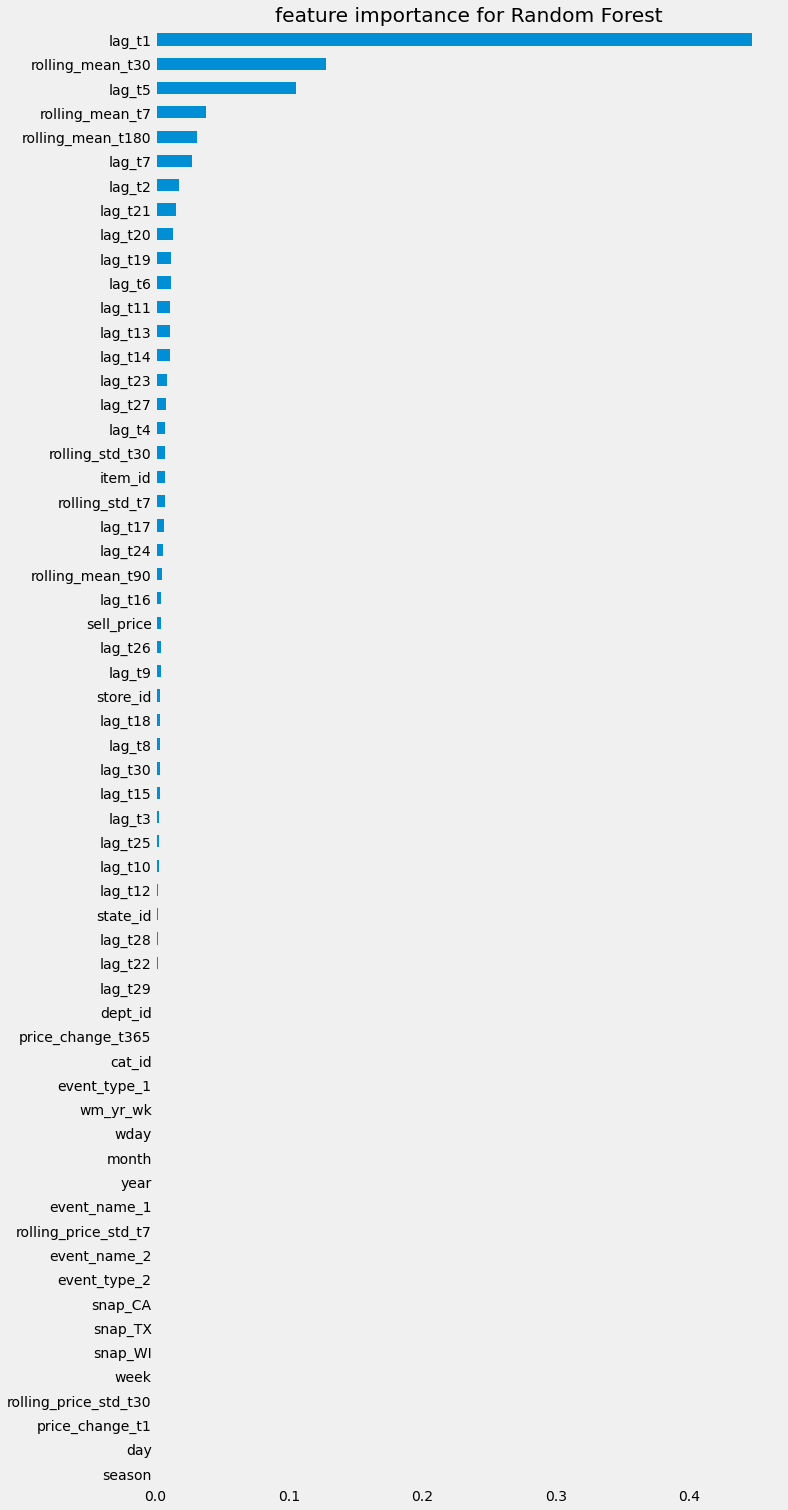

In [136]:
plt.figure(figsize=(10,25))

feature_importance_rf = pd.Series(model_rf2.estimators_[0].feature_importances_, index = x_train.columns).sort_values(ascending = True)
feature_importance_rf.plot.barh()
plt.title('feature importance for Random Forest')
plt.grid()


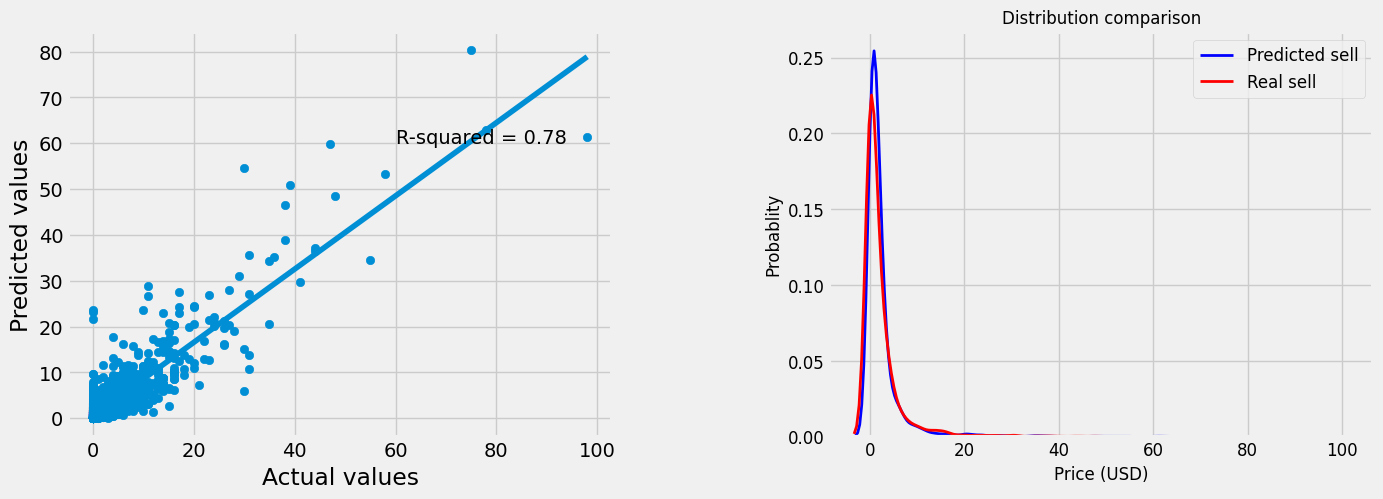

In [147]:
fig = plt.figure(figsize =(15, 5),dpi=100)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = plt.axes(aspect = 'equal')

plt.subplot(121)
y_pred_out = y_pred_rf2
r_squared = (r2_score(y_test, y_pred_out))
plt.scatter(y_test,y_pred_out)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test,y_pred_out, 1))(np.unique(y_test)))
plt.text(60, 60 ,'R-squared = %0.2f' % r_squared)


plt.subplot(122)
sns.distplot(y_pred_out, hist=False,
             kde_kws={'color': 'b', 'lw': 2, 'label': 'Predicted price'})
sns.distplot(y_test, hist=False,
             kde_kws={'color': 'r', 'lw': 2, 'label': 'Real price'})
plt.title('Distribution comparison', fontsize=12)
plt.ylabel('Probablity', fontsize=12)
plt.xlabel('Price (USD)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Predicted sell', 'Real sell'], prop={"size":12})


plt.show()

## Section 5: Business Impact / Insights

To answer my business questions is:

#### What are the main features influencing the sales of product in Walmart?

To summarize, from the prediction result we could see that the feature importances of the food product sales is:

- 1) lag_t7 (40%)
- 2) rolling_mean_t180 (16%)
- 3) rolling_mean_t7 (12.5%)
- 4) lag_t28 (4%)
- 5) rolling_mean_t30 (3%) 

This could imply that the most importance features would fall in the time series categories such as amount of product sold last 7, 28 days, moving average of unit sell 7, 30, 180 days. From features that not related to time, item_id sell_price and store_id come to account that Walmart should focus on. 

This model will benefits in multiple ways, for example: 

- Stocking - it will helps the store retailers to maintain there Stocks according to demand they are expecting
- Creating a promotion for time to time, weekly, event, etc.





#### Is different month and week day affect the sales of the product?

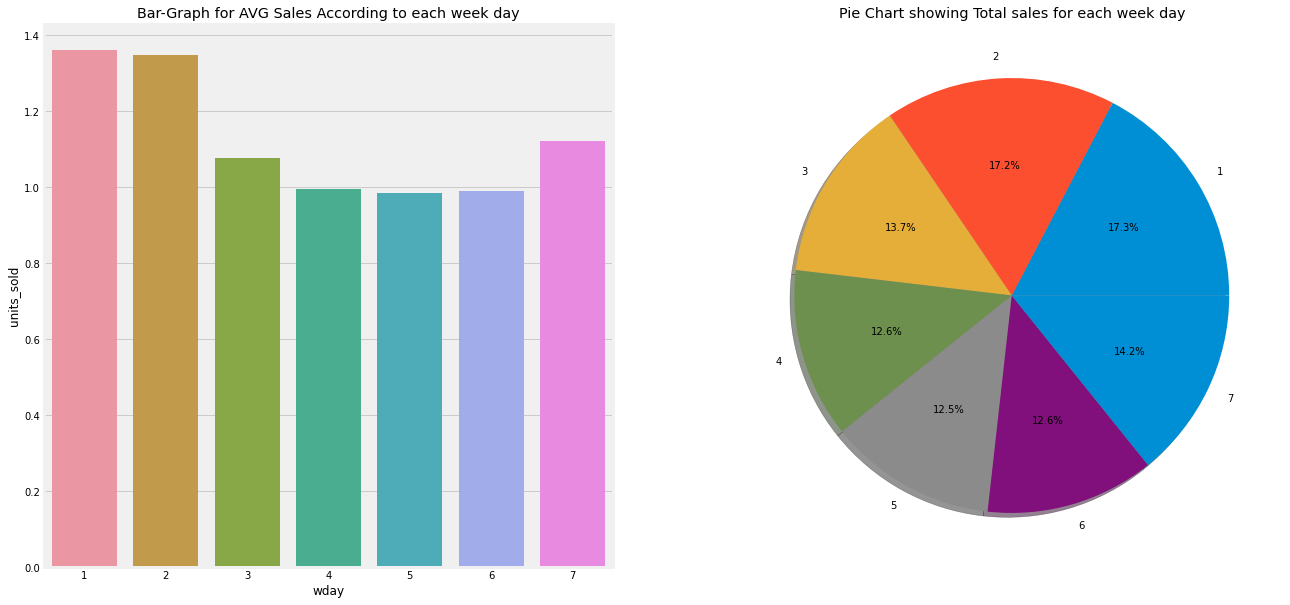

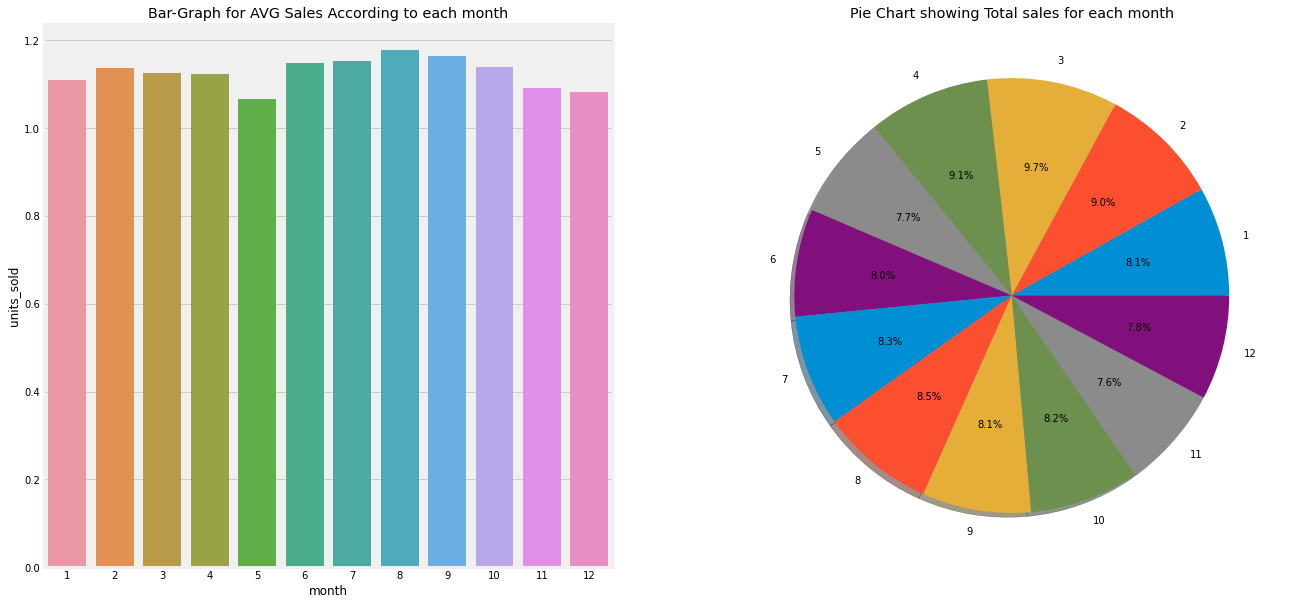

In [324]:
df=data.groupby('wday').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='wday',y='units_sold',data=df)
plt.title("Bar-Graph for AVG Sales According to each week day")

df=data.groupby('wday').sum()
df.reset_index(level=0,inplace=True)
df['perc']=df['units_sold']/sum(df['units_sold'].values)*100
plt.subplot(122)
plt.pie(df['perc'].values,labels=df['wday'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing Total sales for each week day")

df=data.groupby('month').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='month',y='units_sold',data=df)
plt.title("Bar-Graph for AVG Sales According to each month")

df=data.groupby('month').sum()
df.reset_index(level=0,inplace=True)
df['perc']=df['units_sold']/sum(df['units_sold'].values)*100
plt.subplot(122)
plt.pie(df['perc'].values,labels=df['month'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing Total sales for each month")

plt.show()

According to the chart, For weekdays, we can see that on the weekend especially Saturday(1), Sunday(2) are the days that have higher average sales than others. In the time dimension, we could imply that if Walmart wants to contribute the higher product sales on weekdays, they could use the campaign strategies to influence the customer to come and buy the product on weekdays. For the month chart as well, the customer tend to buy a product in Q3 more than other quarters.

# Future Improvement Work

To improve the model performance, we could

- Getting more data, since, very unfortunately I have to remove 4 years of historical data due to memory lacking, this could lead to huge amount of error
- Reduce the overfitting by better tunning on hyperparameters
- Try other model such as random forest or deep learning to improve the accuracy
- Clustering technique to get more insightful information from the data.

In [1]:
!pip install -U notebook-as-pdf

  Created wheel for PyPDF2: filename=PyPDF2-1.26.0-py3-none-any.whl size=61101 sha256=02b5452257043a0af55abb1c785436ca64f159395cc73acede737e66eb18667e
  Stored in directory: c:\users\phongsapon\appdata\local\pip\cache\wheels\80\1a\24\648467ade3a77ed20f35cfd2badd32134e96dd25ca811e64b3
Successfully built PyPDF2
